# Notebook test for ann

## Dataset

In [1]:
import torch
import os
from numpy import ceil, floor

In [3]:
def rotate180(inputs, axis):
    if inputs.size(0) < 32:
        return torch.flip(inputs, [1 + (axis+1)%3, 1 + (axis+2)%3])
    else:
        n32 = floor(inputs.size(0)/32)
        n32 = int(n32)
        for i in range(n32):
            inputs[i*32:(i+1)*32] = torch.flip(inputs[i*32:(i+1)*32], [1 + (axis+1)%3, 1 + (axis+2)%3])
        inputs[n32*32:] = torch.flip(inputs[n32*32:], [1 + (axis+1)%3, 1 + (axis+2)%3])
        return inputs

def mirror_xx(inputs):
    return rotate180(rotate180(inputs, 1), 2)

def periodic_shift(inputs, shift=8):
    if inputs.size(0) < 32:
    # Tensor of size N x nx x ny x nz
    # We shift periodically on nx
        return torch.cat((inputs[:, -shift:, ...], inputs[:,:-shift, ...]), 1)
    else:
        n32 = floor(inputs.size(0)/32)
        n32 = int(n32)
        return torch.cat((inputs[:, -shift:, ...], inputs[:, :n32*32-shift, ...]), 1)



In [4]:
def _data_key(i: int, l, s) -> str:
    return "data_elasticity_3D_128_" + str(i) + "_L" + str(l) + "_S" + str(s) + "_input.pt"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path, n_samples=None, stress_number=0, load_number=0, augment=0, keep_prep=0):
        # # Check that the data path is correct.
        # if not os.path.exists(data_path + _data_key(3, load_number, stress_number)):
        #     print(os.listdir(data_path))
        #     raise ValueError('The data path must lead to a folder with at least one file "' + _data_key(3, load_number, stress_number)
        #                      + ' and here the search path is ' + data_path + '"')
        m = 1
        while os.path.exists(data_path + _data_key(m, load_number, stress_number)):
            m += 1
        # We save the number of datafiles available. Files are named data_elasticity_3D_128_i.pt
        self.number_of_files = m

        # TODO: change max file to nb file in functions
        # store the indicator of how many files we use for data augmentation
        self.augment = int(augment)
        # if not specified, we use all the data available
        self.n_samples = n_samples

        self.data_path = data_path

        # adapt the device to the available hardware
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')

        print("Device: ", self.device)

        # Specify the stress number and the load number
        self.stress_number = stress_number
        self.load_number = load_number

        # this indicator will be used to delete the created datafiles if the preprocessed data is not kept
        self.keep_prep = keep_prep

        # We augment the data if not 0 file augmentation
        if augment:
            self.total_samples = 6*self.n_samples #TODO define a number of augmentations
        else:
            self.total_samples = self.n_samples

        self.input = torch.zeros((0, 1, 64, 64, 64), device=self.device)
        self.output = torch.zeros((0, 1, 64, 64, 64), device=self.device)


    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        if idx < self.total_samples:
            return self.input[idx], self.output[idx]
        else:
            raise IndexError("Index out of range")

    def augmentate(self):
        # Augment the data
        for i in range(int(ceil(self.n_samples/128))):
            key_input = self.data_path + "data_elasticity_3D_128_" + str(i) + "_input.pt"
            key_output = self.data_path + "data_elasticity_3D_128_" + str(i) + "_output.pt"

            if os.path.exists(key_input) and os.path.exists(key_output):
                # Original data
                input0 = torch.load(key_input, map_location=self.device)['input']
                output0 = torch.load(key_output, map_location=self.device)['output']

                # Rotate the data around the y-axis
                input = torch.cat((input0, rotate180(input0, 2)), 0)
                output = torch.cat((output0, rotate180(output0, 2)), 0)

                # Rotate the data around the z-axis
                input = torch.cat((input, rotate180(input0, 3)), 0)
                output = torch.cat((output, rotate180(output0, 3)), 0)

                # Rotate the data around the x-axis for 90 degrees
                input = torch.cat((input, torch.rot90(input0, k=1, dims=(2, 3))), 0)
                output = torch.cat((output, torch.rot90(input0, k=1, dims=(2, 3))), 0)

                # Rotate the data around the x-axis for 180 degrees
                input = torch.cat((input, torch.rot90(input0, k=2, dims=(2, 3))), 0)
                output = torch.cat((output, torch.rot90(input0, k=2, dims=(2, 3))), 0)

                # Rotate the data around the x-axis for 270 degrees
                input = torch.cat((input, torch.rot90(input0, k=3, dims=(2, 3))), 0)
                output = torch.cat((output, torch.rot90(input0, k=3, dims=(2, 3))), 0)

                torch.save({'input': input}, key_input)
                torch.save({'output': output}, key_output)
                print(f"After augmentation the input/output size is {input.size()}") # Size total_samples x 1 x 64 x 64 x 64
            else:
                raise ValueError("Data not preprocessed")

    def load_data(self):
        for i in range(+int(ceil(self.n_samples/128))):
            key_input = self.data_path + _data_key(i, self.load_number, self.stress_number)
            key_output = key_input.replace('input', 'output')
            print(key_input)
            print(key_output)
            os.listdir(self.data_path)
            if os.path.exists(key_input) and os.path.exists(key_output):
                input = torch.load(key_input, map_location=self.device)['input']
                output = torch.load(key_output, map_location=self.device)['output']
                self.input = torch.cat((self.input, input), 0)
                self.output = torch.cat((self.output, output), 0)
            else:
                raise ValueError("Data not preprocessed")
            self.input = self.input[:self.n_samples]
            self.output = self.output[:self.n_samples]
        print(f"After " + str(self.augment) + f" augmentation the input & output size is {self.input.size()}")

    def __del__(self):
        del self.input
        del self.output
        print("Deletion of input/output")
        if 0:#(not self.keep_prep) or self.augment: # We delete the data if chosen or if the file were changed due to data_augmentation
            print("Deleting files")
            for i in range(int(ceil(self.n_samples/128))):
                print("Deletion of file ", i+1, " out of ", int(ceil(self.n_samples/128)))
                key_input = self.data_path + "data_elasticity_3D_128_" + str(i) + "_input.pt"
                key_output = self.data_path + "data_elasticity_3D_128_" + str(i) + "_output.pt"
                if os.path.exists(key_input):
                    print("Deletion of ",key_input)
                    os.remove(key_input)
                if os.path.exists(key_output):
                    print("Deletion of ",key_output)
                    os.remove(key_output)


In [5]:
DATAPATH = '/content/drive/MyDrive/ann_data/'
N_SAMPLE = 128
STRESS_NUMBER= 0
LOAD_NUMBER = 0
AUGMENT = 0

In [6]:
dataset = Dataset(DATAPATH,\
                            n_samples=N_SAMPLE,\
                            stress_number=STRESS_NUMBER,\
                            load_number=LOAD_NUMBER,\
                            augment=AUGMENT)

Device:  cuda


In [7]:
dataset.load_data()

/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_input.pt
/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_output.pt
After 0 augmentation the input & output size is torch.Size([128, 1, 64, 64, 64])


## Model

In [8]:
class UNet3D(torch.nn.Module):
    def __init__(self):
        super(UNet3D, self).__init__()

        self.activation = torch.nn.LeakyReLU()
        self.retrain = False

        # input: 64x64x64, output: 32x32x32
        self.e11 = torch.nn.Conv3d(1, 4, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.e12 = torch.nn.Conv3d(4, 4, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.pool1 = torch.nn.MaxPool3d(kernel_size=2, stride=2)

        # input: 32x32x32, output: 16x16x16
        self.e21 = torch.nn.Conv3d(4, 8, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.e22 = torch.nn.Conv3d(8, 8, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.pool2 = torch.nn.MaxPool3d(kernel_size=2, stride=2)

        # input: 16x16x16, output: 8x8x8
        self.e31 = torch.nn.Conv3d(8, 16, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.e32 = torch.nn.Conv3d(16, 16, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.pool3 = torch.nn.MaxPool3d(kernel_size=2, stride=2)

        # input: 8x8x8, output: 4x4x4
        self.e41 = torch.nn.Conv3d(16, 32, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.e42 = torch.nn.Conv3d(32, 32, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.pool4 = torch.nn.MaxPool3d(kernel_size=2, stride=2)

        # input: 4x4x4, output: 1x1x1
        self.e51 = torch.nn.Conv3d(32, 64, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.e52 = torch.nn.Conv3d(64, 64, kernel_size=3, stride=1, padding="same", padding_mode="circular")

        # Decoder
        # input: 4x4x4, output: 8x8x8
        self.upconv1 = torch.nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.d11 = torch.nn.Conv3d(64, 32, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.d12 = torch.nn.Conv3d(32, 32, kernel_size=3, stride=1, padding="same", padding_mode="circular")

        # input: 8x8x8, output: 16x16x16
        self.upconv2 = torch.nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2)
        self.d21 = torch.nn.Conv3d(32, 16, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.d22 = torch.nn.Conv3d(16, 16, kernel_size=3, stride=1, padding="same", padding_mode="circular")

        # input: 16x16x16, output: 32x32x32
        self.upconv3 = torch.nn.ConvTranspose3d(16, 8, kernel_size=2, stride=2)
        self.d31 = torch.nn.Conv3d(16, 8, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.d32 = torch.nn.Conv3d(8, 8, kernel_size=3, stride=1, padding="same", padding_mode="circular")

        # input: 32x32x32, output: 64x64x64
        self.upconv4 = torch.nn.ConvTranspose3d(8, 4, kernel_size=2, stride=2)
        self.d41 = torch.nn.Conv3d(8, 4, kernel_size=3, stride=1, padding="same", padding_mode="circular")
        self.d42 = torch.nn.Conv3d(4, 4, kernel_size=3, stride=1, padding="same", padding_mode="circular")

        # Output layer 64x64x64
        self.outconv = torch.nn.Conv3d(4, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = self.activation(self.e11(x))
        xe12 = self.activation(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = self.activation(self.e21(xp1))
        xe22 = self.activation(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = self.activation(self.e31(xp2))
        xe32 = self.activation(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = self.activation(self.e41(xp3))
        xe42 = self.activation(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = self.activation(self.e51(xp4))
        xe52 = self.activation(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = self.activation(self.d11(xu11))
        xd12 = self.activation(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = self.activation(self.d21(xu22))
        xd22 = self.activation(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = self.activation(self.d31(xu33))
        xd32 = self.activation(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = self.activation(self.d41(xu44))
        xd42 = self.activation(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

def save_model(model, save_key, epochs):
    # save model
    torch.save(model.state_dict(), DATAPATH + "model/model_" + save_key + "_ep" + str(epochs) + ".pt")
    # save model as script
    model_scripted = torch.jit.script(model)
    model_scripted.save(DATAPATH + "model/model_scripted_" + save_key + "_ep" + str(epochs) + ".pt")

def load_model(model_path_name):
    model = UNet3D()
    model.load_state_dict(torch.load(model_path_name))
    model.eval()
    return model

In [9]:
model = UNet3D()

In [10]:
import time
import matplotlib.pyplot as plt
import matplotlib

## Visualization

In [11]:

def learning(training_indicator, testing_indicator, training_time, save_key, **kwargs):
    OUTPUT_DIR = DATAPATH + 'training/'
    data_min = kwargs.get('vmin', 0)
    data_max = kwargs.get('vmax', max([max(training_indicator), max(testing_indicator)]))

    plt.figure(figsize=(10, 6), dpi=200)

    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams.update({'font.size': 12})
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)

    plt.plot(range(1, len(testing_indicator) + 1), training_indicator, label='Training error', linewidth=1, markersize=7, marker='+')
    plt.plot(range(1, len(testing_indicator) + 1), testing_indicator, label='Testing error', linewidth=1, markersize=7, marker='+')

    plt.xlabel('Epochs')
    plt.xlim([0, len(testing_indicator) + 1])

    plt.yscale('log')
    plt.ylabel('Mean Absolute Error')
    plt.ylim([data_min, data_max])

    plt.grid()
    plt.legend()
    plt.annotate('Epoch duration = ' + str(round(training_time, 2)) + ' s',
                 (0.05 * (len(testing_indicator) + 1), 0.95 * max([max(training_indicator), max(testing_indicator)])))
    # save figure
    plt.savefig(OUTPUT_DIR + 'training_' +save_key + '.png')
    plt.close()

In [12]:

def plot_ITOE(input, target, output, n, axis, save_key, **kwargs):
    # Plot nth slice from 64x64x64 pixel 3D volume for input, target and output with same color scale for output and target
    OUTPUT_DIR = DATAPATH + 'output_slice/'
    input = input.cpu()
    target = target.cpu()
    output = output.cpu()
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes()
    colormap = kwargs.get('cmap', 'jet')
    input_min = kwargs.get('vmin', input.min())
    input_max = kwargs.get('vmax', input.max())
    cmap = plt.get_cmap(colormap, 1024)
    if axis == 0:
        slice = input[n, :, :]
    elif axis == 1:
        slice = input[:, n, :]
    elif axis == 2:
        slice = input[:, :, n]
    mesh = plt.pcolormesh(slice, cmap=cmap, vmin=input_min, vmax=input_max)
    ax.set(xlabel='X', ylabel='Y')
    ax.set_aspect('equal')
    fig.colorbar(mesh)
    plt.savefig(OUTPUT_DIR + 'input_' + save_key + '.png')
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes()
    colormap = kwargs.get('cmap', 'jet')
    cross_min = kwargs.get('vmin', min(target.min(), output.min()))
    cross_max = kwargs.get('vmax', max(target.max(), output.max()))
    cmap = plt.get_cmap(colormap, 1024)
    if axis == 0:
        slice = target[n, :, :]
    elif axis == 1:
        slice = target[:, n, :]
    elif axis == 2:
        slice = target[:, :, n]
    mesh = plt.pcolormesh(slice, cmap=cmap, vmin=cross_min, vmax=cross_max)
    ax.set(xlabel='X', ylabel='Y')
    ax.set_aspect('equal')
    fig.colorbar(mesh)
    plt.savefig(OUTPUT_DIR + 'target_' + save_key + '.png')
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes()
    colormap = kwargs.get('cmap', 'jet')
    if axis == 0:
        slice = output[n, :, :]
    elif axis == 1:
        slice = output[:, n, :]
    elif axis == 2:
        slice = output[:, :, n]
    mesh = plt.pcolormesh(slice, cmap=cmap, vmin=cross_min, vmax=cross_max)
    ax.set(xlabel='X', ylabel='Y')
    ax.set_aspect('equal')
    fig.colorbar(mesh)
    plt.savefig(OUTPUT_DIR + 'output_' + save_key + '.png')
    # plot error between target and output
    error = (target - output).abs().cpu()
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes()
    colormap = kwargs.get('cmap', 'jet')
    error_min = kwargs.get('vmin', error.min())
    error_max = kwargs.get('vmax', error.max())
    cmap = plt.get_cmap(colormap, 1024)
    if axis == 0:
        slice = error[n, :, :]
    elif axis == 1:
        slice = error[:, n, :]
    elif axis == 2:
        slice = error[:, :, n]
    mesh = plt.pcolormesh(slice, cmap=cmap, vmin=error_min, vmax=error_max)
    ax.set(xlabel='X', ylabel='Y')
    ax.set_aspect('equal')
    fig.colorbar(mesh)
    plt.savefig(OUTPUT_DIR + 'error_' + save_key + '.png')
    plt.close()

In [13]:


def volume(x, y, z, data, save_key=None, **kwargs):
    OUTPUT_DIR = DATAPATH + 'output_image/'
    x = x.cpu()
    y = y.cpu()
    z = z.cpu()
    data = data.cpu()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dz = z[1] - z[0]

    x = x - dx / 2
    x = x.add(x[-1] + dx)
    y = y - dy / 2
    y = y.add(y[-1] + dy)
    z = z - dz / 2
    z = z.add(z[-1] + dz)

    X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')

    colormap = kwargs.get('cmap', 'jet')
    data_min = kwargs.get('vmin', data.min())
    data_max = kwargs.get('vmax', data.max())

    norm = matplotlib.colors.Normalize(vmin=data_min, vmax=data_max)
    data = norm(data)

    args = {'linewidth': 0, 'antialiased': False, 'rstride': 1, 'cstride': 1, 'shade': False}
    cmap = plt.get_cmap(colormap, 1024)

    my_col = cmap.__call__(data[:, :, -1])
    ax.plot_surface(X[:, :, -1], Y[:, :, -1], Z[:, :, -1], facecolors=my_col, **args)

    my_col = cmap.__call__(data[:, 0, :])
    ax.plot_surface(X[:, 0, :], Y[:, 0, :], Z[:, 0, :], facecolors=my_col, **args)

    my_col = cmap.__call__(data[0, :, :])
    ax.plot_surface(X[0, :, :], Y[0, :, :], Z[0, :, :], facecolors=my_col, **args)

    # my_col = cmap.__call__(data[:, :, 0])
    # ax.plot_surface(X[:, :, 0], Y[:, :, 0], Z[:, :, 0], facecolors=my_col, **args)

    # my_col = cmap.__call__(data[:, -1, :])
    # ax.plot_surface(X[:, -1, :], Y[:, -1, :], Z[:, -1, :], facecolors=my_col, **args)

    # my_col = cmap.__call__(data[-1, :, :])
    # test = ax.plot_surface(X[-1, :, :], Y[-1, :, :], Z[-1, :, :], facecolors=my_col, **args)

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    zmin, zmax = z.min(), z.max()

    # edges_kw = dict(color='k', linewidth=1, zorder=1e3)
    # ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
    # # ax.plot([xmin, xmax], [ymax, ymax], zmin, **edges_kw)
    # ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
    # ax.plot([xmin, xmax], [ymax, ymax], zmax, **edges_kw)

    # ax.plot([xmin, xmin], [ymin, ymax], zmin, **edges_kw)
    # # ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
    # ax.plot([xmin, xmin], [ymin, ymax], zmax, **edges_kw)
    # ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)

    # ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
    # ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
    # ax.plot([xmin, xmin], [ymax, ymax], [zmin, zmax], **edges_kw)
    # # ax.plot([xmax, xmax], [ymax, ymax], [zmin, zmax], **edges_kw)

    ax.set(xlabel='X', ylabel='Y', zlabel='Z')

    ax.view_init(15, -105, 0)

    ax.set(xlim=[x.min(), x.max()], ylim=[y.min(), y.max()], zlim=[z.min(), z.max()])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm, ax=ax)

    ax.set_proj_type('ortho')
    ax.set_aspect('equal')
    # save the figure
    #plt.savefig(OUTPUT_DIR + 'volume_' + save_key + '.png')

    plt.show()

In [14]:
import csv

In [15]:
def write_results(results):
    #write to results.csv
    if not os.path.exists('results.csv'):
        fields = ['n_samples',
                'epoch',
                'stress_number',
                'load_number' ,
                'augment_files',
                'testing_loss',
                'training_loss',
                'training_time',
                'testing_time']

        with open('results.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(fields)
            file.close()
    with open('results.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(results)
        file.close()

In [16]:
# Rotate along x-axis 180°
def augment1(inputs, outputs):
  inputs2, outputs2 = torch.rot90(inputs, k=2, dims=[3,4]), torch.rot90(outputs, k=2, dims=[3,4])
  return torch.cat((inputs, inputs2)), torch.cat((outputs, outputs2))

# Rotate along y-axis 180°
def augment2(inputs, outputs):
  inputs2, outputs2 = torch.rot90(inputs, k=2, dims=[2,4]), torch.rot90(outputs, k=2, dims=[2,4])
  return torch.cat((inputs, inputs2)), torch.cat((outputs, outputs2))

# Rotate along z-axis 180°
def augment3(inputs, outputs):
  inputs2, outputs2 = torch.rot90(inputs, k=2, dims=[2,3]), torch.rot90(outputs, k=2, dims=[2,3])
  return torch.cat((inputs, inputs2)), torch.cat((outputs, outputs2))

# flip along y,z axis
def augment4(inputs, outputs):
  inputs2, outputs2 = torch.flip(inputs, dims=[3,4]), torch.flip(outputs, dims=[3,4])
  return torch.cat((inputs, inputs2)), torch.cat((outputs, outputs2))

# flip along x,z axis
def augment5(inputs, outputs):
  inputs2, outputs2 = torch.flip(inputs, dims=[2,4]), torch.flip(outputs, dims=[2,4])
  return torch.cat((inputs, inputs2)), torch.cat((outputs, outputs2))

# flip along x,y axis
def augment6(inputs, outputs):
  inputs2, outputs2 = torch.flip(inputs, dims=[2,3]), torch.flip(outputs, dims=[2,3])
  return torch.cat((inputs, inputs2)), torch.cat((outputs, outputs2))


In [17]:
x = torch.arange(8).view(1, 1, 2, 2, 2)
print(x)

tensor([[[[[0, 1],
           [2, 3]],

          [[4, 5],
           [6, 7]]]]])


In [18]:
y1 = [[ [[[2, 3],
          [0, 1]],

         [[6, 7],
          [4, 5]]] ]]
print(augment4(x, x))

(tensor([[[[[0, 1],
           [2, 3]],

          [[4, 5],
           [6, 7]]]],



        [[[[3, 2],
           [1, 0]],

          [[7, 6],
           [5, 4]]]]]), tensor([[[[[0, 1],
           [2, 3]],

          [[4, 5],
           [6, 7]]]],



        [[[[3, 2],
           [1, 0]],

          [[7, 6],
           [5, 4]]]]]))


In [19]:
torch.manual_seed(0)

class TrainerTester:
    def __init__(self, model: UNet3D, dataset: Dataset, augment=0) -> None:
        # Set the model, the dataset and the device without initialization
        self.model = model
        self.dataset = dataset
        self.device = self.dataset.device
        self.model.to(self.device)

        # TODO: set these parameters from a configuration file
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.lr = 1e-3
        self.split_ratio = 0.75
        self.augment_operators = augment
        self.batch_size = 8
        self.stop_criteria = 0.02
        self.max_epochs = int(500*128/self.dataset.n_samples) # Set the same computing time for each dataset

        self.training_time = list()
        self.testing_time = list()
        self.training_indicator = list()
        self.testing_indicator = list()
        self.epochs = 0

        self.train_loader, self.test_loader = self.split_data()

    def split_data(self):
        split = int(len(self.dataset) * self.split_ratio)

        train_inputs, test_inputs = self.dataset.input[:split], self.dataset.input[split:]
        train_outputs, test_outputs = self.dataset.output[:split], self.dataset.output[split:]

        if self.augment_operators > 1:
          train_inputs, train_outputs = augment1(train_inputs, train_outputs)
        if self.augment_operators > 2:
          train_inputs, train_outputs = augment2(train_inputs, train_outputs)
        if self.augment_operators > 3:
          train_inputs, train_outputs = augment3(train_inputs, train_outputs)
        if self.augment_operators > 4:
          train_inputs, train_outputs = augment4(train_inputs, train_outputs)
        if self.augment_operators > 5:
          train_inputs, train_outputs = augment5(train_inputs, train_outputs)
        if self.augment_operators > 6:
          train_inputs, train_outputs = augment6(train_inputs, train_outputs)


        train_dataset = torch.utils.data.TensorDataset(train_inputs, train_outputs)
        test_dataset = torch.utils.data.TensorDataset(test_inputs, test_outputs)

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=self.batch_size, shuffle=False)
        return train_loader, test_loader

# train function
    def train_loop(self):
        indicator = torch.zeros((len(self.train_loader),))
        self.model.train()
        for batch, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            indicator[batch] = torch.abs(output - target).mean()
        return indicator.mean().item()

# test function
    def test_loop(self):
        indicator = torch.zeros((len(self.test_loader),))
        self.model.eval()
        with torch.no_grad():
            for batch, (data, target) in enumerate(self.test_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                indicator[batch] = torch.abs(output - target).mean()
        return indicator.mean().item()

    def train(self):
        epoch = 0
        while (epoch < self.max_epochs):
            start = time.time()
            train_indicator = self.train_loop()
            self.training_indicator.append(train_indicator)
            self.training_time.append(time.time() - start)

            start = time.time()
            test_indicator = self.test_loop()
            self.testing_indicator.append(test_indicator)
            self.testing_time.append(time.time() - start)

            epoch += 1
            print(f"Epoch {epoch} - Training Loss: {train_indicator:.4f} - Testing Loss: {test_indicator:.4f}")

            save_key = f"N{self.dataset.n_samples}_stress{self.dataset.stress_number}_loading{self.dataset.load_number}"
            learning(self.training_indicator, self.testing_indicator, self.training_time[-1], save_key)

            if self.testing_indicator[-1] < self.stop_criteria or epoch == self.max_epochs:
                self.compute_lowest_loss()
                break
            if epoch % self.max_epochs//4 + 1 == 0:
                self.model.save_model(save_key=save_key, epochs=epoch)

        print("Total training time: ", sum(self.training_time))
        self.epochs = epoch
        write_results([str(self.dataset.n_samples),
                       str(self.epochs),
                       str(self.dataset.stress_number),
                       str(self.dataset.load_number),
                       str(self.dataset.augment),
                       str(self.testing_indicator),
                       str(self.training_indicator),
                       str(sum(self.training_time)),
                       str(sum(self.testing_time))])

    def get_max_loss_training(self):
        if len(self.training_indicator) == 0:
            print("No training indicator computed")
            return
        indicator = torch.zeros((len(self.train_loader),))
        print("Computing the maximum loss for training")
        with torch.no_grad():
            for batch, (data, target) in enumerate(self.train_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                indicator[batch] = torch.abs(output - target).mean()

        index = torch.argmax(indicator)
        return index, indicator.flatten()[index].item()

    def get_max_loss_testing(self):
        if len(self.testing_indicator) == 0:
            print("No testing indicator computed")
            return
        indicator = torch.zeros((len(self.test_loader),))
        print("Computing the maximum loss for testing")
        with torch.no_grad():
            for batch, (data, target) in enumerate(self.test_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                indicator[batch] = torch.abs(output - target).mean()

        index = torch.argmax(indicator)
        return index, indicator.flatten()[index].item()

    def compute_lowest_loss(self):
        index, indicator = self.get_max_loss_testing()

        input = self.test_loader.dataset[index][0]
        target = self.test_loader.dataset[index][1]
        output = self.model(input.to(self.device).unsqueeze(0)).detach()

        save_key = f"N{self.dataset.n_samples}_stress{self.dataset.stress_number}_loading{self.dataset.load_number}"
        x, y, z = torch.arange(64), torch.arange(64), torch.arange(64) # create grid
        volume(x ,y ,z , input[0, ...], save_key=save_key + '_input')
        volume(x ,y ,z , target[0, ...], vmin=0, vmax=3.5, save_key=save_key + '_target')
        volume(x ,y ,z , output[0, 0, ...], vmin=0, vmax=3.5, save_key=save_key+ '_output')
        print(indicator)

        plot_ITOE(input[0, ...], target[0, ...], output[0, 0, ...], index, 0, save_key=save_key)

    def get_mean_loss_training(self):
        if len(self.training_indicator) == 0:
            print("No training indicator computed")
            return
        indicator = torch.zeros((len(self.train_loader), 1))
        print("Computing the maximum loss for training")
        with torch.no_grad():
            for batch, (data, target) in enumerate(self.train_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                indicator[batch, :] = torch.abs(output - target).mean()
        return indicator.mean().item()


    def get_mean_loss_testing(self):
        if len(self.testing_indicator) == 0:
            print("No testing indicator computed")
            return
        indicator = torch.zeros((len(self.test_loader), 1))
        print("Computing the maximum loss for testing")
        with torch.no_grad():
            for batch, (data, target) in enumerate(self.test_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                indicator[batch, :] = torch.abs(output - target).mean()
        return indicator.mean().item()





——————————————————————
For number of samples: 128
——————————————————————

Device:  cuda
Dataset is created with 128 samples, stress number 0 and load number 0.

/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_input.pt
/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_output.pt
After 0 augmentation the input & output size is torch.Size([128, 1, 64, 64, 64])
Dataset loaded.
Lenght of dataset: 128

Type of model: UNet3D with activation function LeakyReLU.
Training infrastructure is set.
Start training.
Deletion of input/output
Epoch 1 - Training Loss: 1.3611 - Testing Loss: 0.5726


<ipython-input-12-22178c67671a>:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([data_min, data_max])


Epoch 2 - Training Loss: 1.2003 - Testing Loss: 1.2590
Epoch 3 - Training Loss: 1.2472 - Testing Loss: 1.1839
Epoch 4 - Training Loss: 1.0970 - Testing Loss: 0.8647
Epoch 5 - Training Loss: 0.4447 - Testing Loss: 0.1832
Epoch 6 - Training Loss: 0.1799 - Testing Loss: 0.1672
Epoch 7 - Training Loss: 0.1808 - Testing Loss: 0.1826
Epoch 8 - Training Loss: 0.1641 - Testing Loss: 0.1589
Epoch 9 - Training Loss: 0.1574 - Testing Loss: 0.1614
Epoch 10 - Training Loss: 0.1534 - Testing Loss: 0.1505
Epoch 11 - Training Loss: 0.1496 - Testing Loss: 0.1489
Epoch 12 - Training Loss: 0.1437 - Testing Loss: 0.1452
Epoch 13 - Training Loss: 0.1432 - Testing Loss: 0.1441
Epoch 14 - Training Loss: 0.1406 - Testing Loss: 0.1426
Epoch 15 - Training Loss: 0.1410 - Testing Loss: 0.1412
Epoch 16 - Training Loss: 0.1394 - Testing Loss: 0.1402
Epoch 17 - Training Loss: 0.1381 - Testing Loss: 0.1397
Epoch 18 - Training Loss: 0.1379 - Testing Loss: 0.1405
Epoch 19 - Training Loss: 0.1367 - Testing Loss: 0.1383


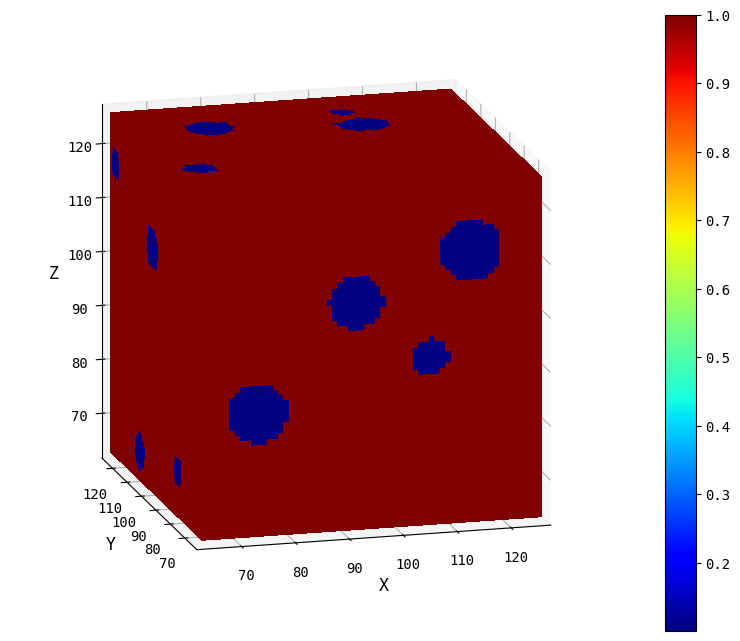

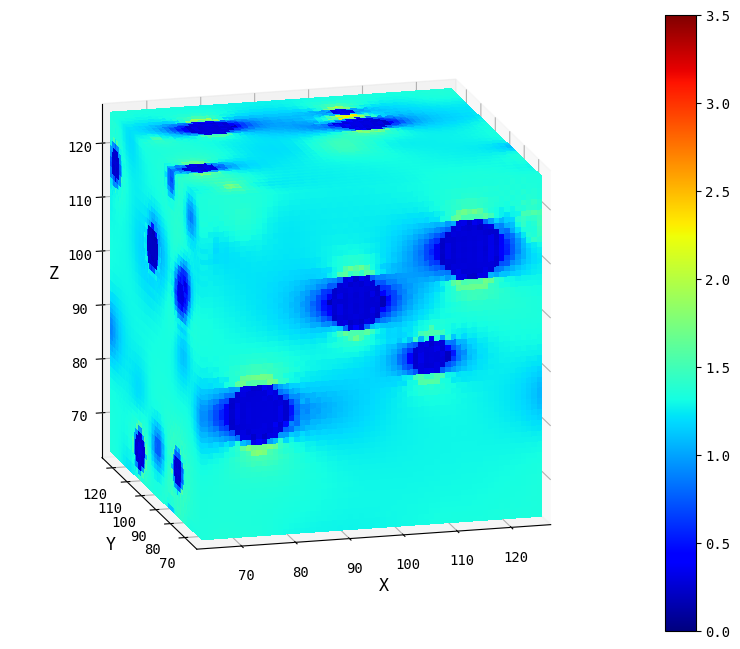

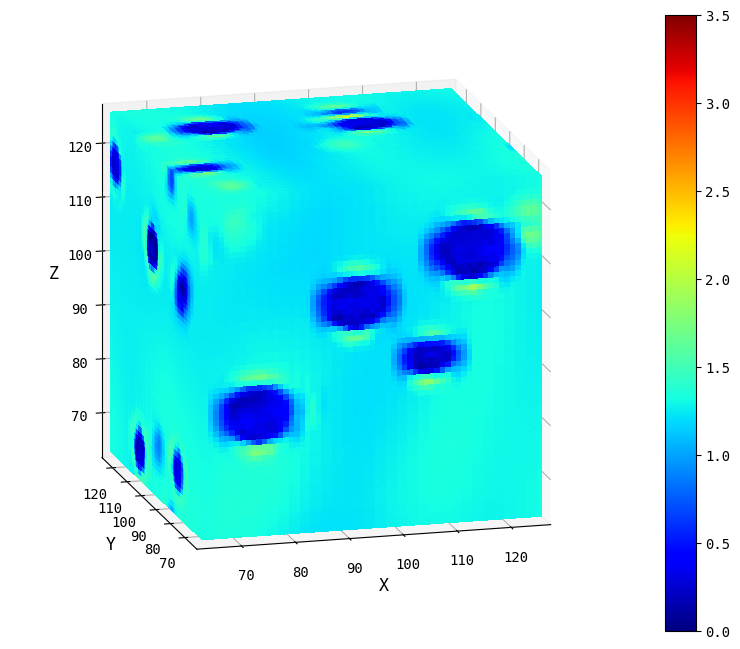

0.07465709745883942
Total training time:  525.1650624275208
End of training. Number of epochs:  200


——————————————————————
For number of samples: 128
——————————————————————

Device:  cuda
Dataset is created with 128 samples, stress number 0 and load number 0.

/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_input.pt
/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_output.pt
After 0 augmentation the input & output size is torch.Size([128, 1, 64, 64, 64])
Dataset loaded.
Lenght of dataset: 128

Type of model: UNet3D with activation function LeakyReLU.
Training infrastructure is set.
Start training.
Epoch 1 - Training Loss: 1.4763 - Testing Loss: 1.3495
Epoch 2 - Training Loss: 0.8460 - Testing Loss: 0.6116
Deletion of input/output
Epoch 3 - Training Loss: 0.3311 - Testing Loss: 0.2456
Epoch 4 - Training Loss: 0.1875 - Testing Loss: 0.1537
Epoch 5 - Training Loss: 0.1621 - Testing Loss: 0.1540
Epoch 6 - Training Loss: 0.1445 - Testing Loss: 0.1506
Epoch 7 - 

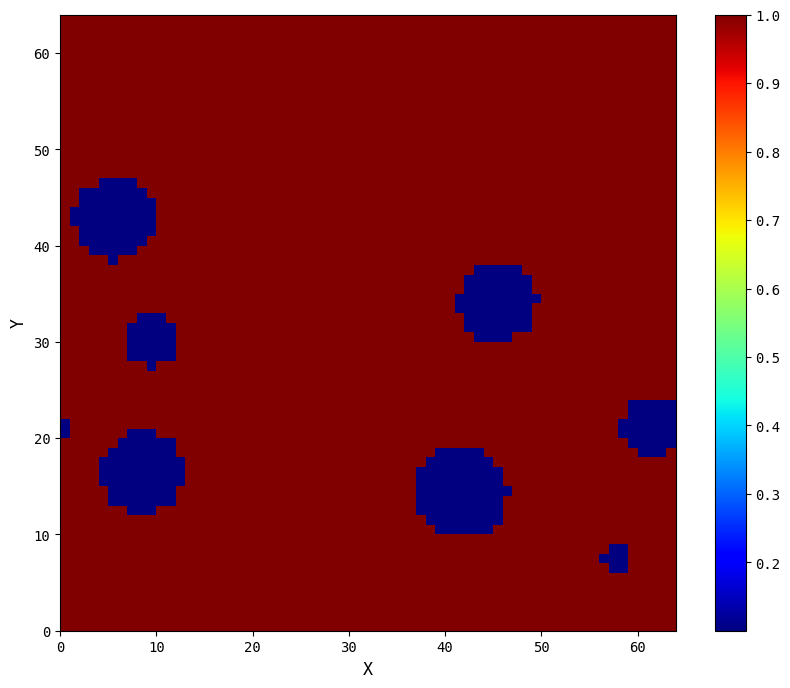

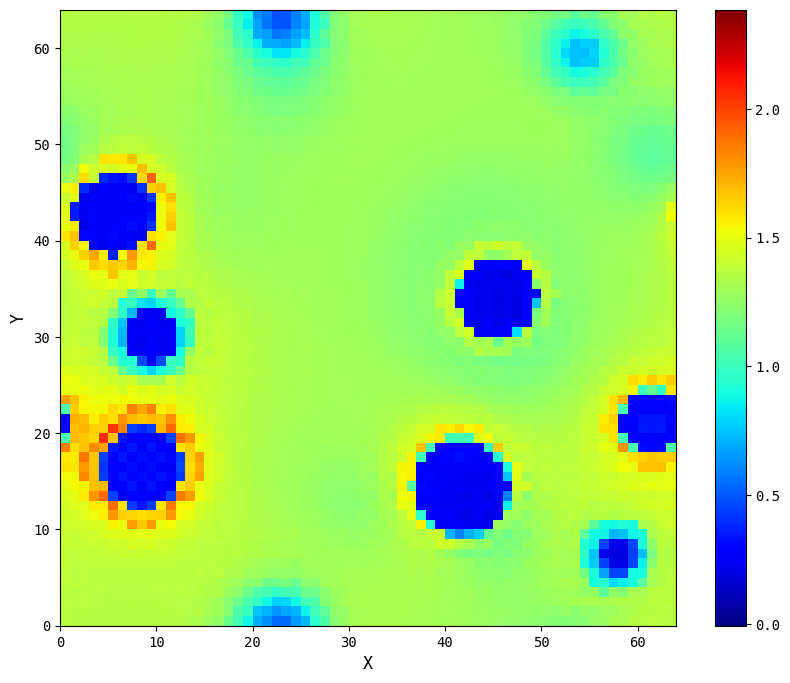

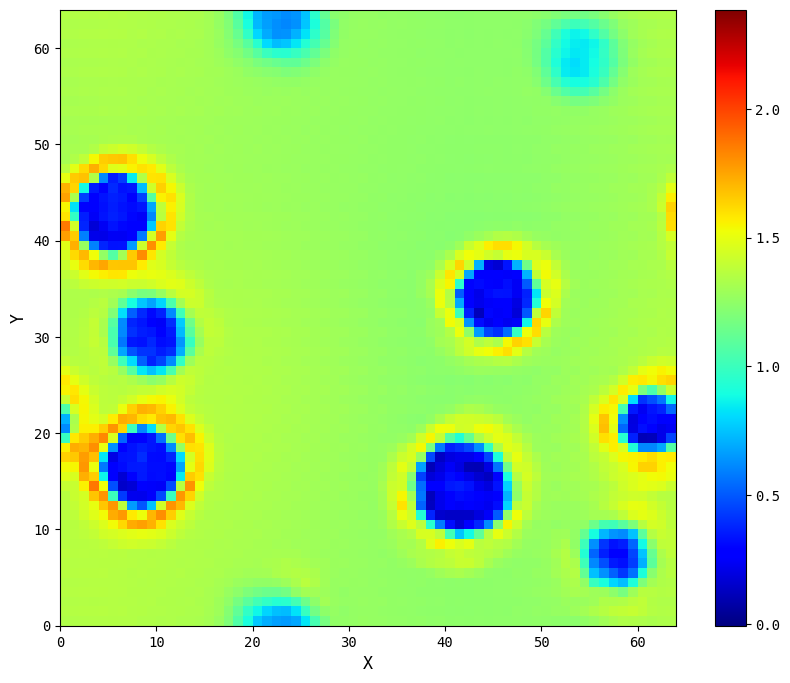

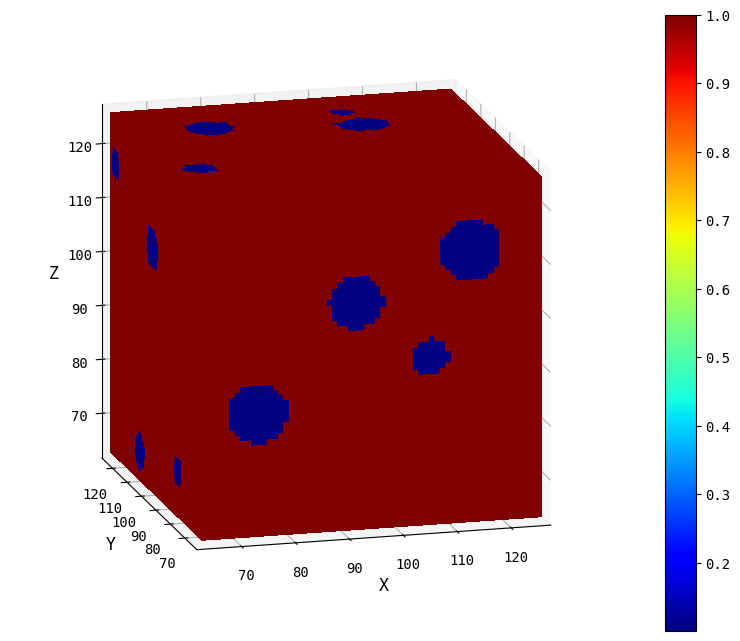

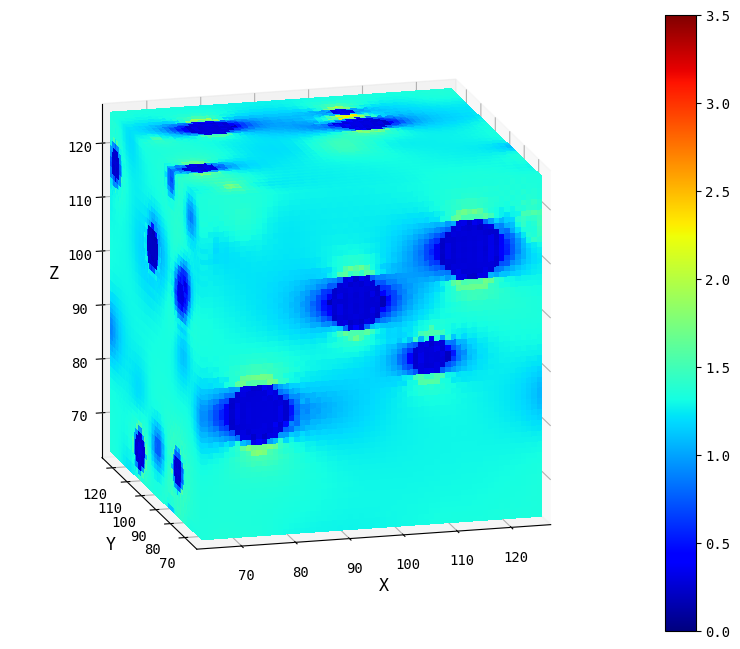

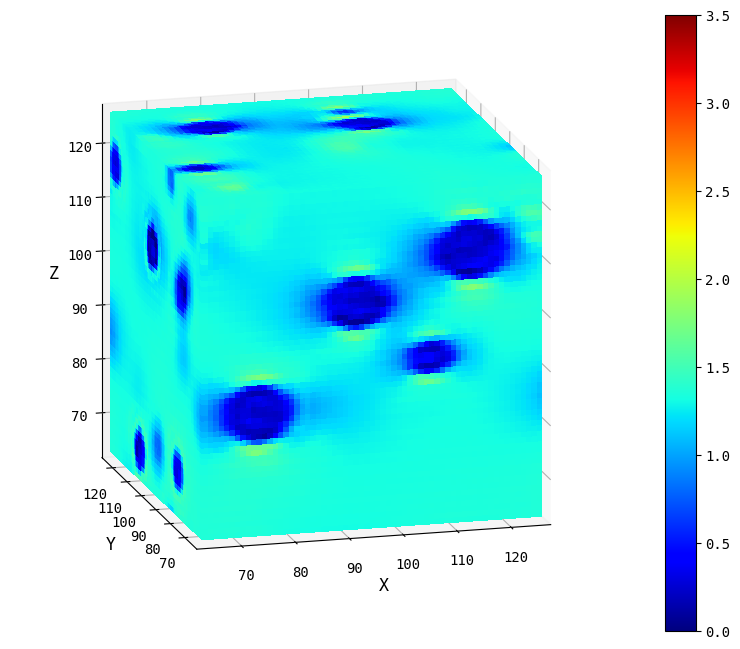

0.05796821787953377
Total training time:  525.273805141449
End of training. Number of epochs:  200


——————————————————————
For number of samples: 128
——————————————————————

Device:  cuda
Dataset is created with 128 samples, stress number 0 and load number 0.

/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_input.pt
/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_output.pt
After 0 augmentation the input & output size is torch.Size([128, 1, 64, 64, 64])
Dataset loaded.
Lenght of dataset: 128

Type of model: UNet3D with activation function LeakyReLU.
Training infrastructure is set.
Start training.
Epoch 1 - Training Loss: 0.8111 - Testing Loss: 0.1863
Epoch 2 - Training Loss: 0.1772 - Testing Loss: 0.1762
Deletion of input/output
Epoch 3 - Training Loss: 0.1665 - Testing Loss: 0.1718
Epoch 4 - Training Loss: 0.1622 - Testing Loss: 0.1649
Epoch 5 - Training Loss: 0.1578 - Testing Loss: 0.1563
Epoch 6 - Training Loss: 0.1516 - Testing Loss: 0.1481
Epoch 7 - T

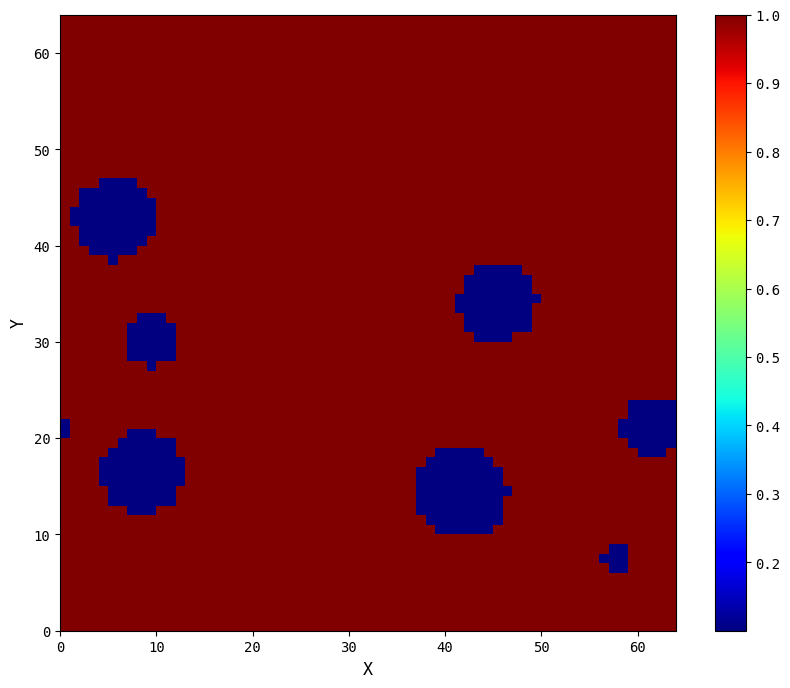

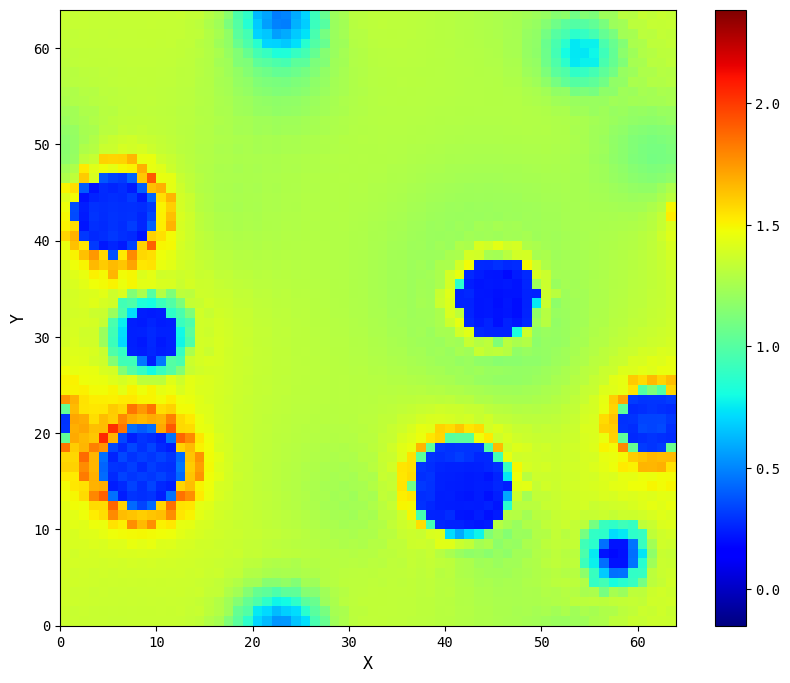

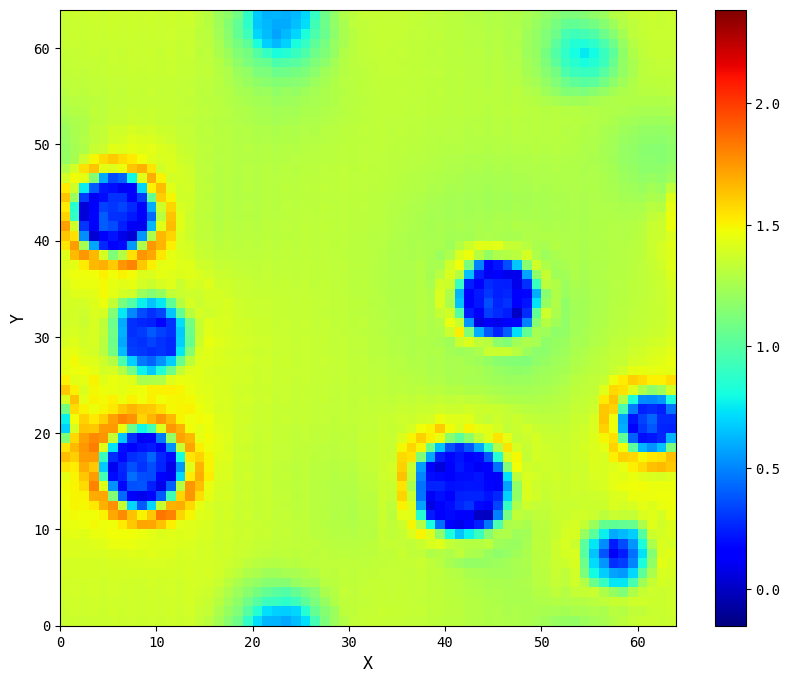

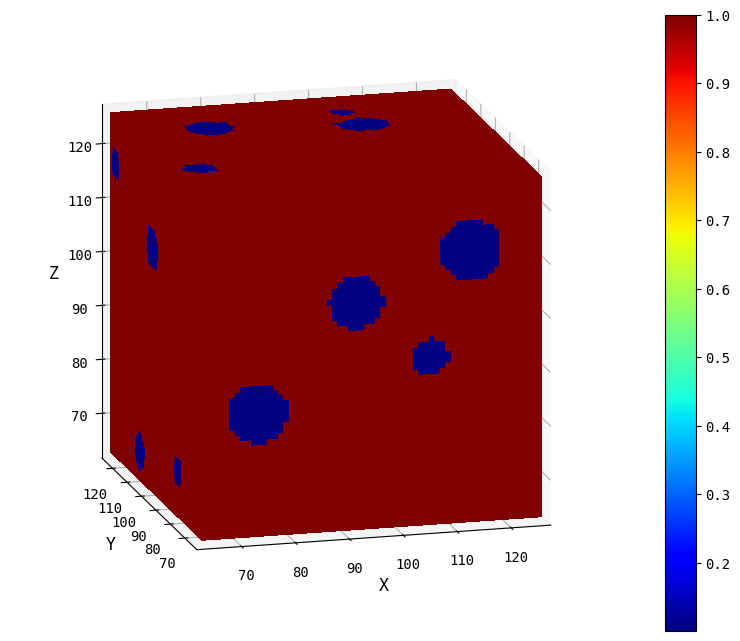

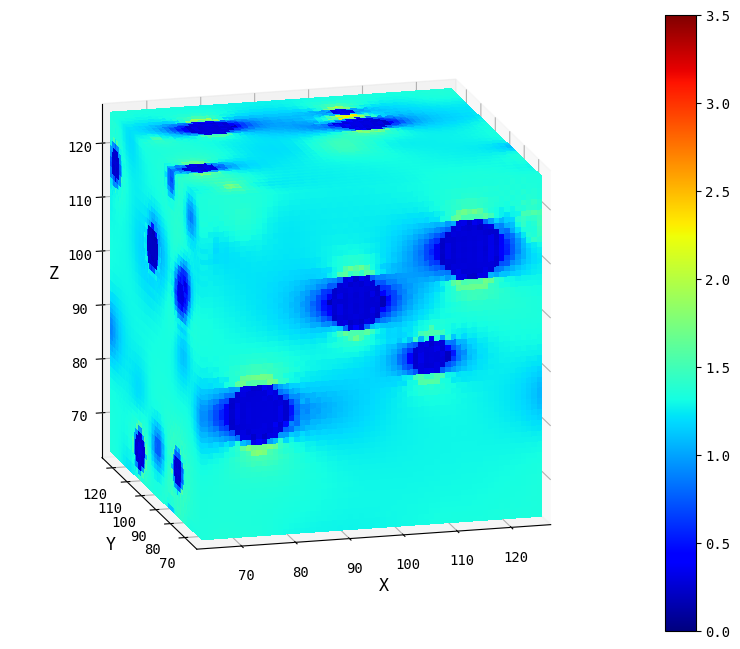

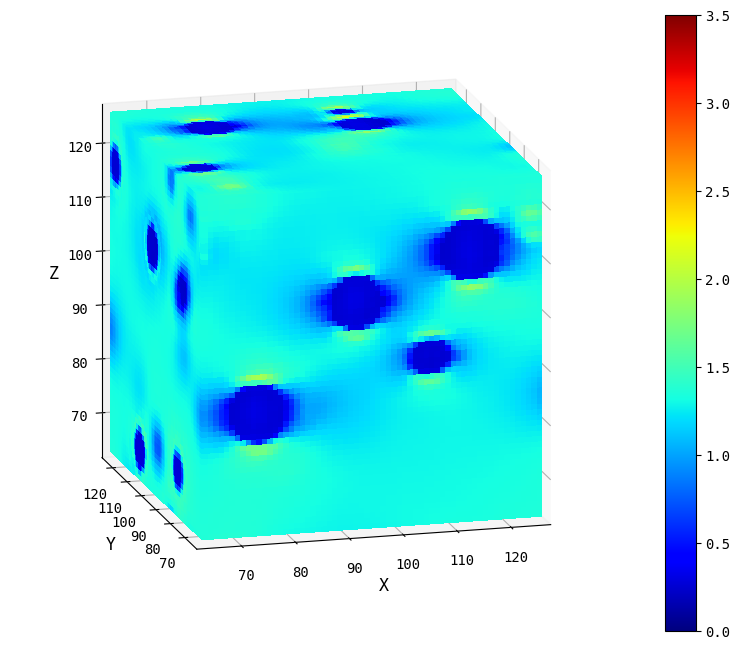

0.031575027853250504
Total training time:  1050.7465040683746
End of training. Number of epochs:  200


——————————————————————
For number of samples: 128
——————————————————————

Device:  cuda
Dataset is created with 128 samples, stress number 0 and load number 0.

/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_input.pt
/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_output.pt
After 0 augmentation the input & output size is torch.Size([128, 1, 64, 64, 64])
Dataset loaded.
Lenght of dataset: 128

Type of model: UNet3D with activation function LeakyReLU.
Training infrastructure is set.
Start training.
Epoch 1 - Training Loss: 0.5503 - Testing Loss: 0.1833
Epoch 2 - Training Loss: 0.1773 - Testing Loss: 0.1718
Epoch 3 - Training Loss: 0.1565 - Testing Loss: 0.1533
Epoch 4 - Training Loss: 0.1471 - Testing Loss: 0.1480
Epoch 5 - Training Loss: 0.1437 - Testing Loss: 0.1409
Epoch 6 - Training Loss: 0.1352 - Testing Loss: 0.1321
Epoch 7 - Training Loss: 0.1308 -

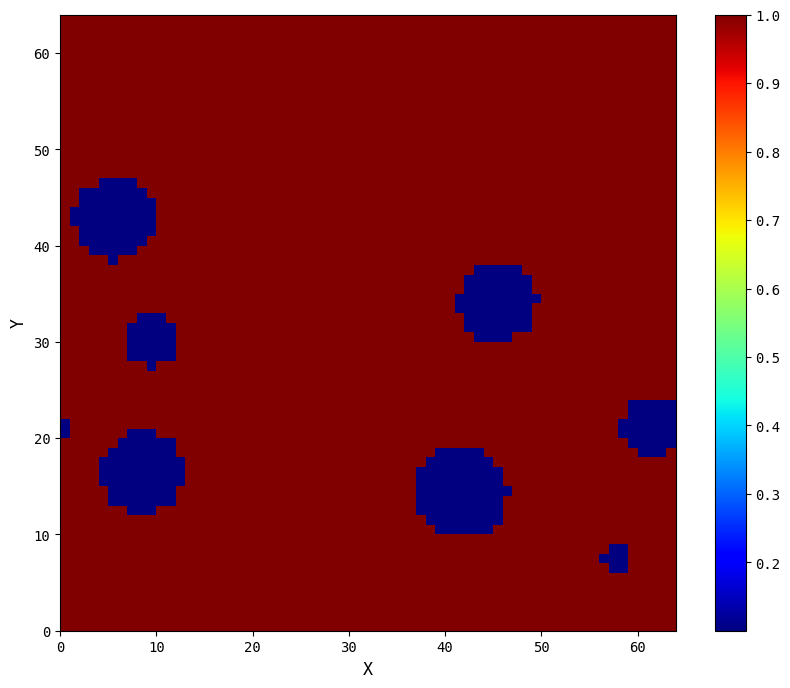

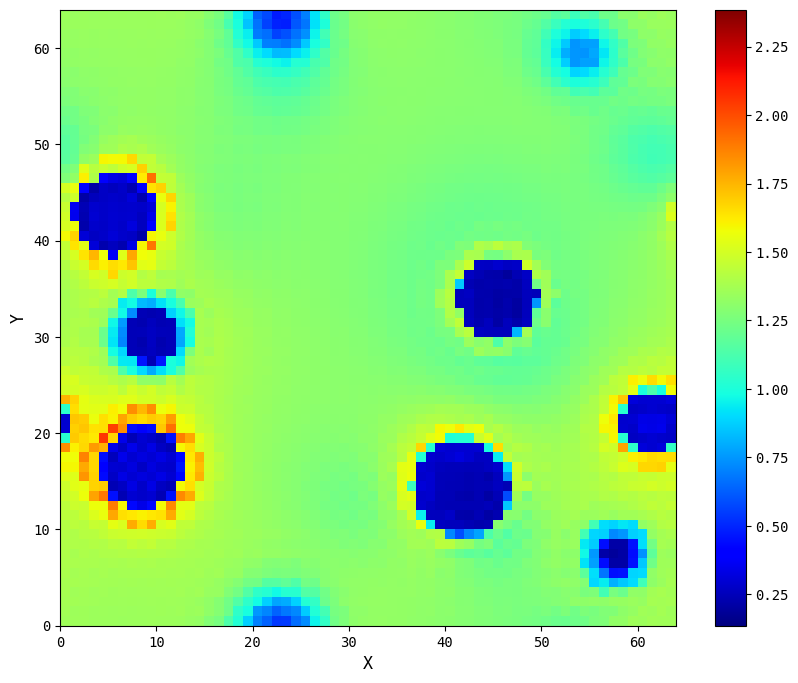

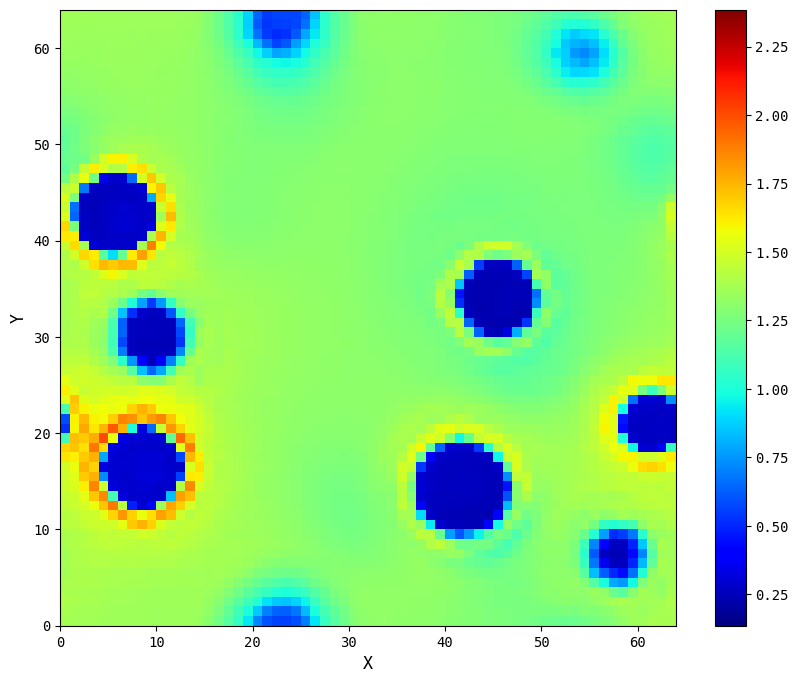

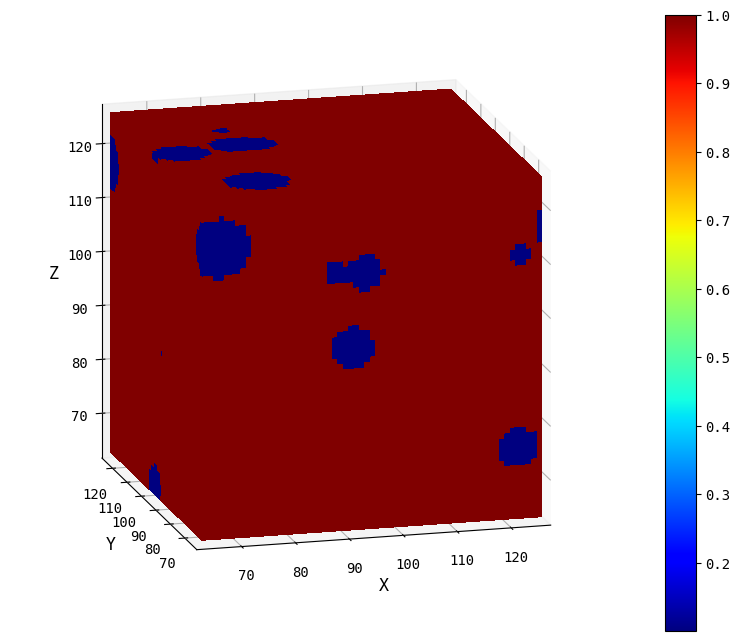

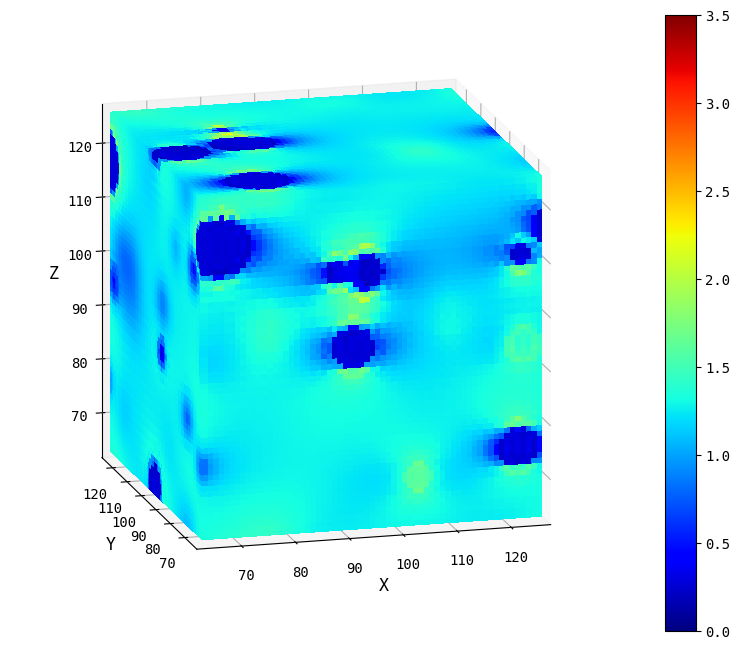

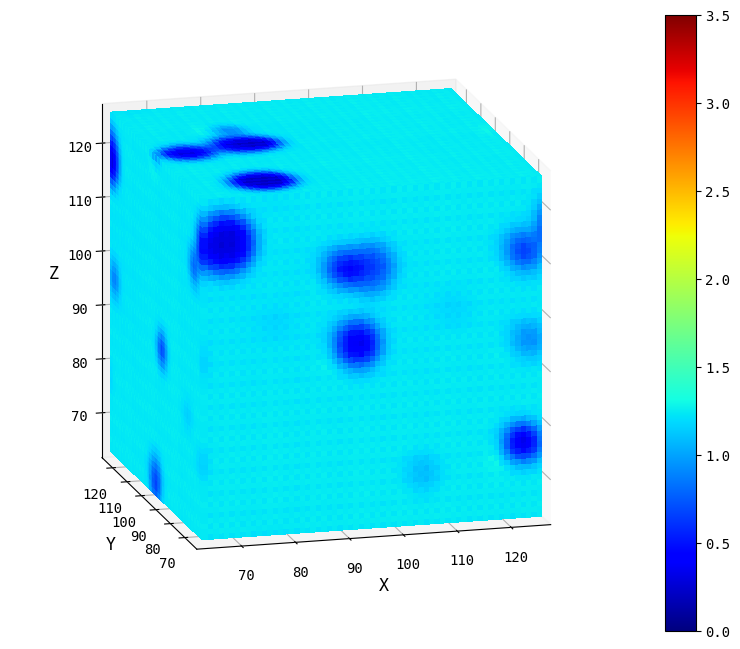

0.15482497215270996
Total training time:  2100.7305314540863
End of training. Number of epochs:  200


——————————————————————
For number of samples: 128
——————————————————————

Device:  cuda
Dataset is created with 128 samples, stress number 0 and load number 0.

/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_input.pt
/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_output.pt
After 0 augmentation the input & output size is torch.Size([128, 1, 64, 64, 64])
Dataset loaded.
Lenght of dataset: 128

Type of model: UNet3D with activation function LeakyReLU.
Training infrastructure is set.
Start training.
Epoch 1 - Training Loss: 0.3952 - Testing Loss: 0.1695
Deletion of input/output
Epoch 2 - Training Loss: 0.1557 - Testing Loss: 0.1519
Epoch 3 - Training Loss: 0.1469 - Testing Loss: 0.1464
Epoch 4 - Training Loss: 0.1442 - Testing Loss: 0.1461
Epoch 5 - Training Loss: 0.1439 - Testing Loss: 0.1446
Epoch 6 - Training Loss: 0.1425 - Testing Loss: 0.1410
Epoch 7 -

KeyboardInterrupt: 

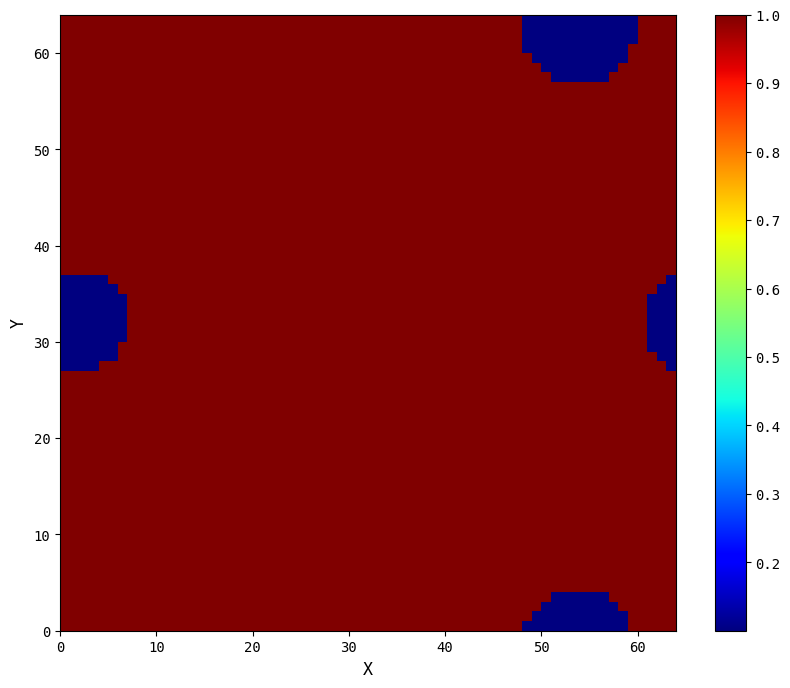

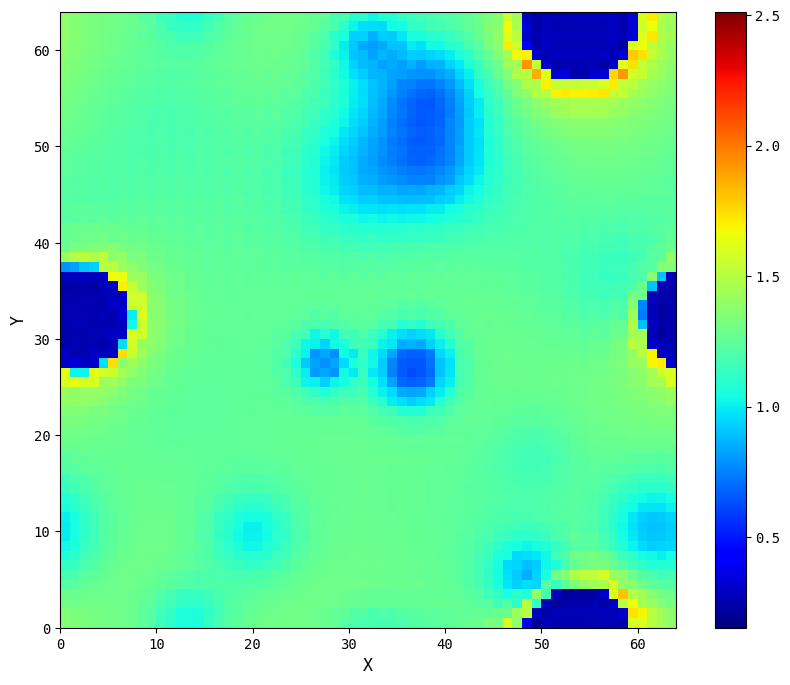

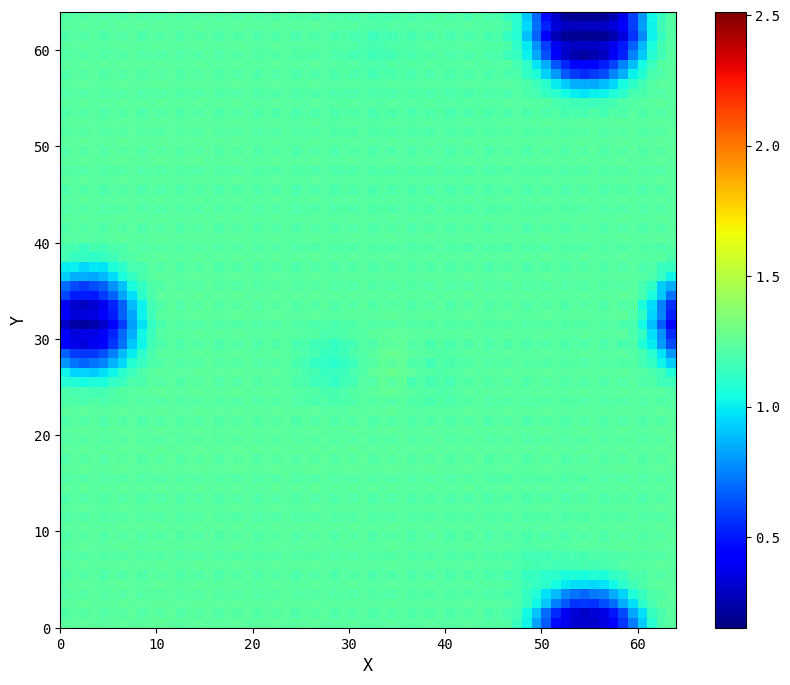

In [ ]:
    n_sample = 128
    DATA_PATH = DATAPATH
    STRESS_NUMBER = 0
    LOAD_NUMBER = 0
    AUGMENTS = [0, 1, 2, 3, 4, 5, 6]

    for augment in AUGMENTS:
        print(f"\n\n——————————————————————\nFor number of samples: {n_sample}\n——————————————————————\n")
        # parser = Parser()
        # print(f"Arguments of parser are: {parser.get_args()}")
        # print(f"Number of samples: {parser.get_n_samples()}")
        # print(f"Number of epochs: {parser.get_n_epochs()}")
        # print(f"Stress number: {parser.get_stress_number()}")
        # print(f"Load number: {parser.get_load_number()}")
        # print(f"Augment: {parser.get_augment()}")
        # print(f"Model name: {parser.get_model_name()}")
        # print(f"Data path: {parser.get_data_path()}\n")

        # dataset = Dataset(parser.get_data_path(),\
        #                     n_samples=parser.get_n_samples(),\
        #                     stress_number=parser.get_stress_number(),\
        #                     load_number=parser.get_load_number(),\
        #                     augment=parser.get_augment())

        dataset = Dataset(DATA_PATH,\
                            n_samples=n_sample,\
                            stress_number=STRESS_NUMBER,\
                            load_number=LOAD_NUMBER,\
                            augment=AUGMENT)

        print(f"Dataset is created with {dataset.n_samples} samples, stress number {dataset.stress_number} and load number {dataset.load_number}.\n")
        if dataset.augment:
            dataset.augmentate()
            print("Augmentation of dataset is done.")
        dataset.load_data()
        print("Dataset loaded.")
        print(f"Lenght of dataset: {len(dataset)}\n")

        model = UNet3D()
        print(f"Type of model: UNet3D with activation function LeakyReLU.")

        training = TrainerTester(model, dataset, augment=augment)
        training.max_epochs = 200
        print("Training infrastructure is set.")

        print("Start training.")
        training.train() # Train the model
        print("End of training. Number of epochs: ", training.epochs)
        # save the model
        save_key = f"N{dataset.n_samples}_stress{dataset.stress_number}_loading{dataset.load_number}_augment{augment}"
        save_model(model, save_key=save_key, epochs=training.epochs)

In [ ]:
save_key = f"N{dataset.n_samples}_stress{dataset.stress_number}_loading{dataset.load_number}"
save_model(model, save_key=save_key, epochs=training.epochs)

In [ ]:
index, indicator = training.get_max_loss_testing()

input = training.test_loader.dataset[index][0]
target = training.test_loader.dataset[index][1]
output = training.model(input.to(training.device).unsqueeze(0)).detach()

save_key = f"N{training.dataset.n_samples}_stress{training.dataset.stress_number}_loading{training.dataset.load_number}"
x, y, z = torch.arange(64), torch.arange(64), torch.arange(64) # create grid
volume(x ,y ,z , input[0, ...], save_key=save_key + '_input')
volume(x ,y ,z , target[0, ...], vmin=0, vmax=3.5, save_key=save_key + '_target')
volume(x ,y ,z , output[0, 0, ...], vmin=0, vmax=3.5, save_key=save_key+ '_output')
print(indicator)
plot_ITOE(input[0, ...], target[0, ...], output[0, 0, ...], index, 0, save_key=save_key)

In [ ]:
index, indicator = training.get_max_loss_training()

input = training.train_loader.dataset[index][0]
target = training.train_loader.dataset[index][1]
output = training.model(input.to(training.device).unsqueeze(0)).detach()

save_key = f"N{training.dataset.n_samples}_stress{training.dataset.stress_number}_loading{training.dataset.load_number}"
x, y, z = torch.arange(64), torch.arange(64), torch.arange(64) # create grid
volume(x ,y ,z , input[0, ...], save_key=save_key + '_input')
volume(x ,y ,z , target[0, ...], vmin=0, vmax=3.5, save_key=save_key + '_target')
volume(x ,y ,z , output[0, 0, ...], vmin=0, vmax=3.5, save_key=save_key+ '_output')
print(indicator)
plot_ITOE(input[0, ...], target[0, ...], output[0, 0, ...], index, 0, save_key=save_key)



——————————————————————
For number of samples: 16
——————————————————————

Device:  cuda
Dataset is created with 16 samples, stress number 0 and load number 0.

/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_input.pt
/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_output.pt
After 0 augmentation the input & output size is torch.Size([16, 1, 64, 64, 64])
Dataset loaded.
Lenght of dataset: 16

Type of model: UNet3D with activation function LeakyReLU.
Training infrastructure is set.
Start training.
Deletion of input/output
Epoch 1 - Training Loss: 0.7143 - Testing Loss: 0.6768
yYYYYY
UUUUUU


<ipython-input-61-77d5823d3c28>:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([data_min, data_max])


EEEEEE
Epoch 2 - Training Loss: 0.6084 - Testing Loss: 0.3749
yYYYYY
UUUUUU
EEEEEE
Computing the maximum loss for testing


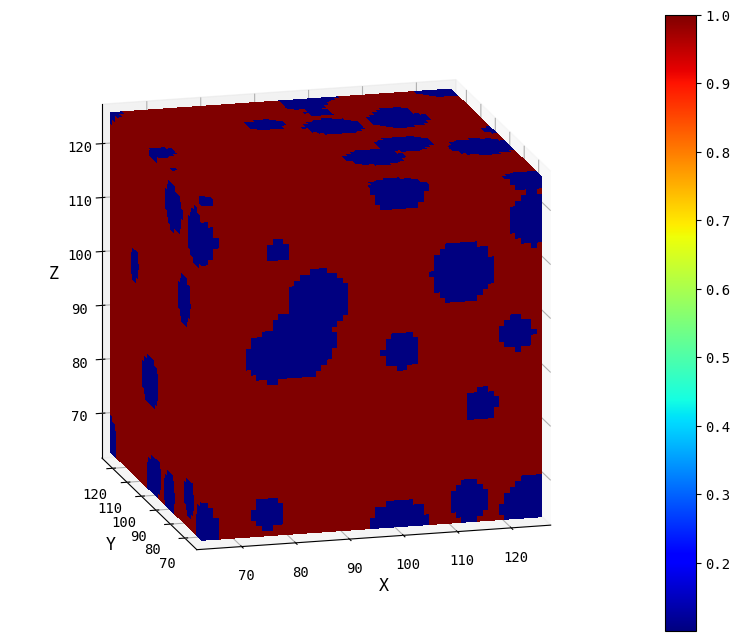

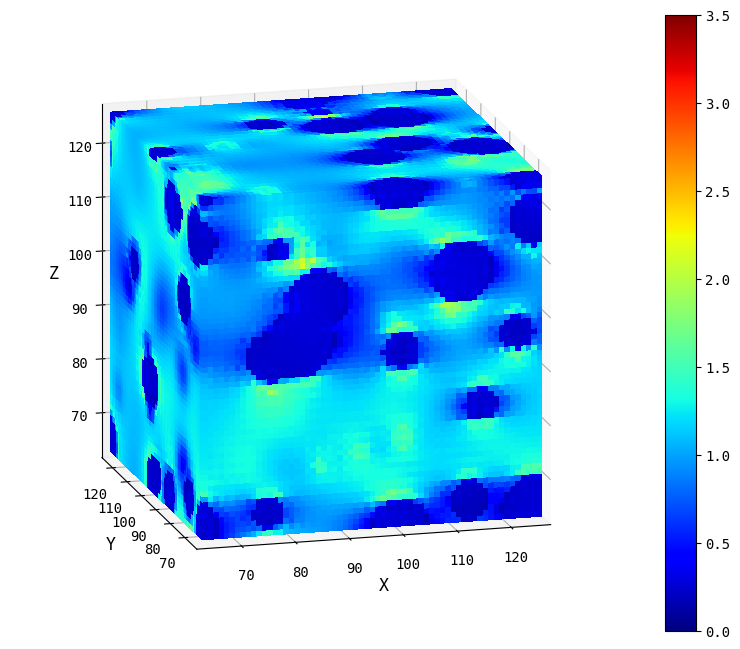

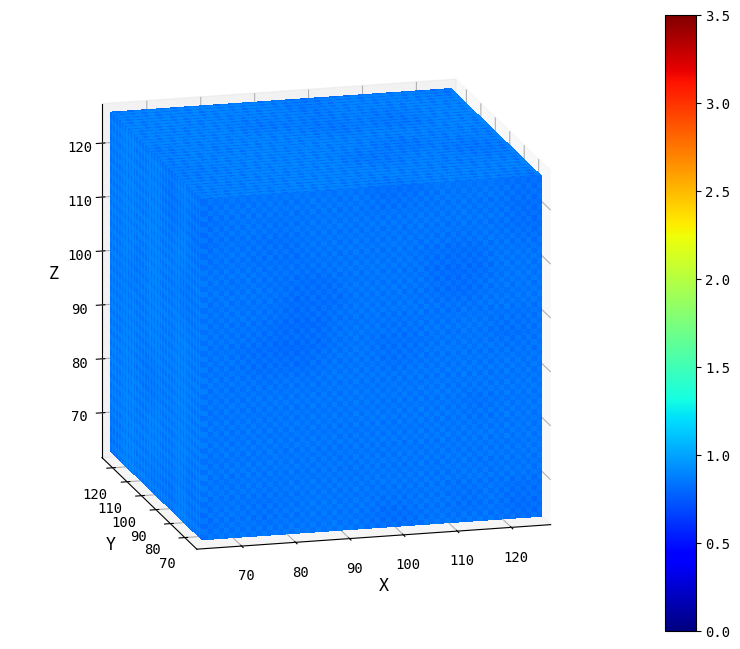

0.37489408254623413
Total training time:  5.390296220779419
End of training. Number of epochs:  2


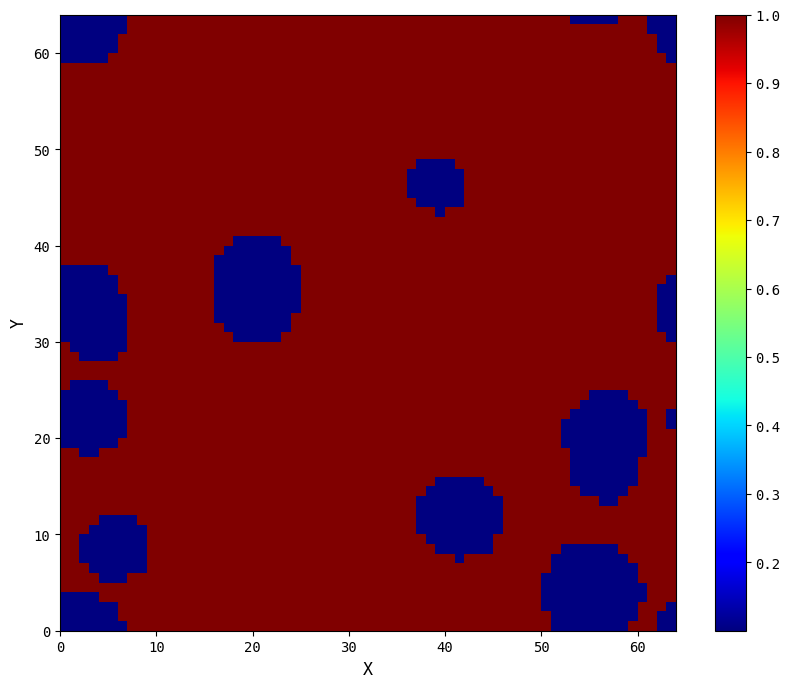

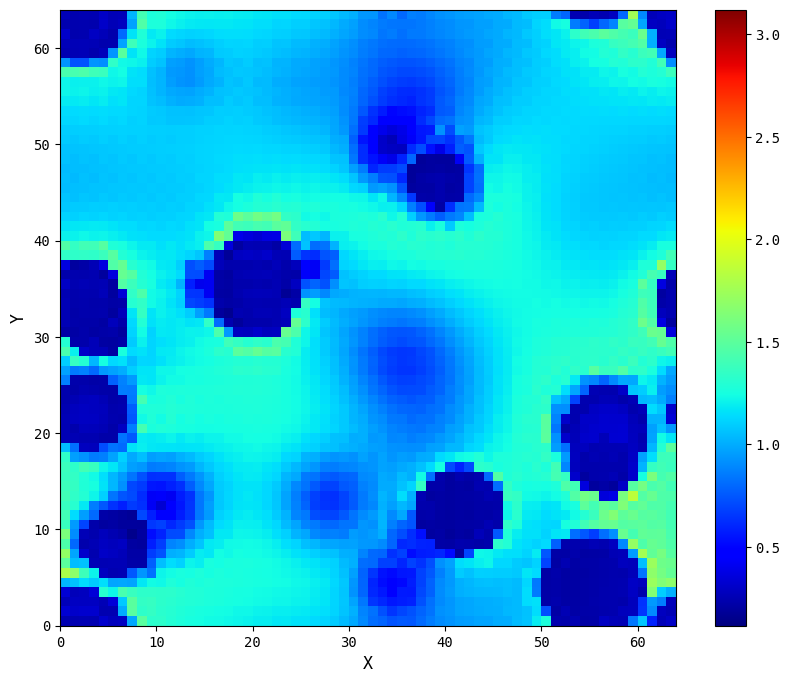

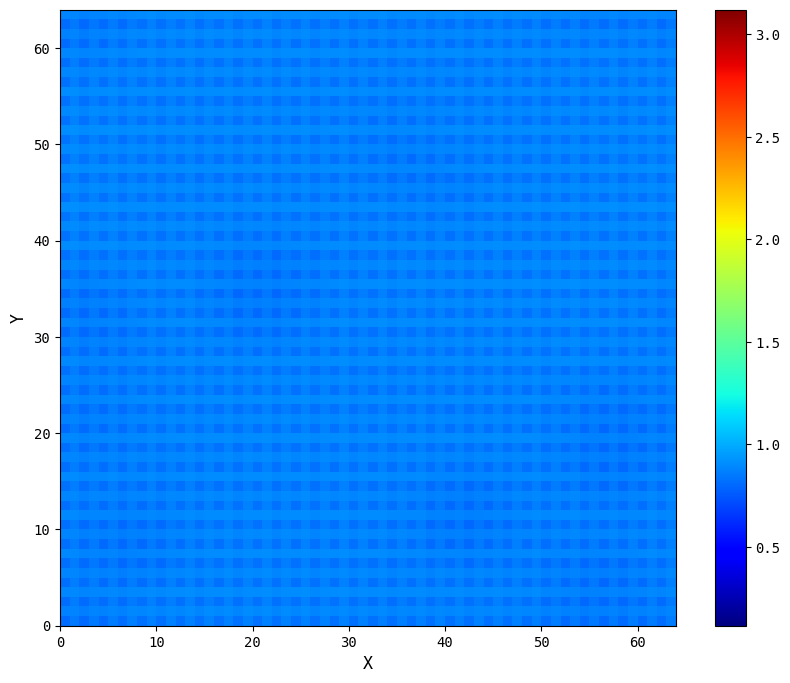

In [ ]:
    N_SAMPLES = [16]
    DATA_PATH = DATAPATH
    STRESS_NUMBER = 0
    LOAD_NUMBER = 0
    AUGMENTS = [0]

    for n_sample in N_SAMPLES:
        print(f"\n\n——————————————————————\nFor number of samples: {n_sample}\n——————————————————————\n")
        # parser = Parser()
        # print(f"Arguments of parser are: {parser.get_args()}")
        # print(f"Number of samples: {parser.get_n_samples()}")
        # print(f"Number of epochs: {parser.get_n_epochs()}")
        # print(f"Stress number: {parser.get_stress_number()}")
        # print(f"Load number: {parser.get_load_number()}")
        # print(f"Augment: {parser.get_augment()}")
        # print(f"Model name: {parser.get_model_name()}")
        # print(f"Data path: {parser.get_data_path()}\n")

        # dataset = Dataset(parser.get_data_path(),\
        #                     n_samples=parser.get_n_samples(),\
        #                     stress_number=parser.get_stress_number(),\
        #                     load_number=parser.get_load_number(),\
        #                     augment=parser.get_augment())

        dataset = Dataset(DATA_PATH,\
                            n_samples=n_sample,\
                            stress_number=STRESS_NUMBER,\
                            load_number=LOAD_NUMBER,\
                            augment=AUGMENT)

        print(f"Dataset is created with {dataset.n_samples} samples, stress number {dataset.stress_number} and load number {dataset.load_number}.\n")
        if dataset.augment:
            dataset.augmentate()
            print("Augmentation of dataset is done.")
        dataset.load_data()
        print("Dataset loaded.")
        print(f"Lenght of dataset: {len(dataset)}\n")

        model = UNet3D()
        print(f"Type of model: UNet3D with activation function LeakyReLU.")

        training = TrainerTester(model, dataset, augment=augment)
        training.max_epochs = 2
        print("Training infrastructure is set.")

        print("Start training.")
        training.train() # Train the model
        print("End of training. Number of epochs: ", training.epochs)
        # save the model
        save_key = f"N{dataset.n_samples}_stress{dataset.stress_number}_loading{dataset.load_number}_augment{augment}"
        save_model(model, save_key=save_key, epochs=training.epochs)

In [ ]:
    N_SAMPLES = [64]
    DATA_PATH = DATAPATH
    STRESS_NUMBER = 0
    LOAD_NUMBER = 0
    AUGMENTS = [0]

    for n_sample in N_SAMPLES:
        print(f"\n\n——————————————————————\nFor number of samples: {n_sample}\n——————————————————————\n")
        # parser = Parser()
        # print(f"Arguments of parser are: {parser.get_args()}")
        # print(f"Number of samples: {parser.get_n_samples()}")
        # print(f"Number of epochs: {parser.get_n_epochs()}")
        # print(f"Stress number: {parser.get_stress_number()}")
        # print(f"Load number: {parser.get_load_number()}")
        # print(f"Augment: {parser.get_augment()}")
        # print(f"Model name: {parser.get_model_name()}")
        # print(f"Data path: {parser.get_data_path()}\n")

        # dataset = Dataset(parser.get_data_path(),\
        #                     n_samples=parser.get_n_samples(),\
        #                     stress_number=parser.get_stress_number(),\
        #                     load_number=parser.get_load_number(),\
        #                     augment=parser.get_augment())

        dataset = Dataset(DATA_PATH,\
                            n_samples=n_sample,\
                            stress_number=STRESS_NUMBER,\
                            load_number=LOAD_NUMBER,\
                            augment=AUGMENT)

        print(f"Dataset is created with {dataset.n_samples} samples, stress number {dataset.stress_number} and load number {dataset.load_number}.\n")
        if dataset.augment:
            dataset.augmentate()
            print("Augmentation of dataset is done.")
        dataset.load_data()
        print("Dataset loaded.")
        print(f"Lenght of dataset: {len(dataset)}\n")

        model = UNet3D()
        print(f"Type of model: UNet3D with activation function LeakyReLU.")

        training = TrainerTester(model, dataset)
        print("Training infrastructure is set.")

        print("Start training.")
        training.train() # Train the model
        print("End of training. Number of epochs: ", training.epochs)
        # save the model
        save_key = f"N{dataset.n_samples}_stress{dataset.stress_number}_loading{dataset.load_number}_augment{augment}"
        save_model(model, save_key=save_key, epochs=training.epochs)



——————————————————————
For number of samples: 32
——————————————————————

Device:  cuda
Dataset is created with 32 samples, stress number 0 and load number 0.

/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_input.pt
/content/drive/MyDrive/ann_data/data_elasticity_3D_128_0_L0_S0_output.pt
Deletion of input/output
After 0 augmentation the input & output size is torch.Size([32, 1, 64, 64, 64])
Dataset loaded.
Lenght of dataset: 32

Type of model: UNet3D with activation function LeakyReLU.
Training infrastructure is set.
Start training.
Epoch 1 - Training Loss: 1.4028 - Testing Loss: 1.3915


<ipython-input-12-274a448c7b09>:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([data_min, data_max])


Epoch 2 - Training Loss: 1.3911 - Testing Loss: 1.3779
Epoch 3 - Training Loss: 1.3728 - Testing Loss: 1.3353
Epoch 4 - Training Loss: 1.2522 - Testing Loss: 0.5818
Epoch 5 - Training Loss: 1.2006 - Testing Loss: 0.7927
Epoch 6 - Training Loss: 1.0106 - Testing Loss: 1.2187
Epoch 7 - Training Loss: 1.2419 - Testing Loss: 1.2601
Epoch 8 - Training Loss: 1.2655 - Testing Loss: 1.2617
Epoch 9 - Training Loss: 1.2627 - Testing Loss: 1.2520
Epoch 10 - Training Loss: 1.2506 - Testing Loss: 1.2357
Epoch 11 - Training Loss: 1.2325 - Testing Loss: 1.2138
Epoch 12 - Training Loss: 1.2084 - Testing Loss: 1.1853
Epoch 13 - Training Loss: 1.1773 - Testing Loss: 1.1475
Epoch 14 - Training Loss: 1.1330 - Testing Loss: 1.0869
Epoch 15 - Training Loss: 1.0621 - Testing Loss: 0.9935
Epoch 16 - Training Loss: 0.9552 - Testing Loss: 0.8575
Epoch 17 - Training Loss: 0.8018 - Testing Loss: 0.6655
Epoch 18 - Training Loss: 0.5835 - Testing Loss: 0.3752
Epoch 19 - Training Loss: 0.3219 - Testing Loss: 0.3012


In [ ]:
del dataset
del model
del training

NameError: name 'dataset' is not defined

In [ ]:
    N_SAMPLES = [32]
    DATA_PATH = DATAPATH
    STRESS_NUMBER = 0
    LOAD_NUMBER = 0
    AUGMENTS = [0]

    for n_sample in N_SAMPLES:
        print(f"\n\n——————————————————————\nFor number of samples: {n_sample}\n——————————————————————\n")
        # parser = Parser()
        # print(f"Arguments of parser are: {parser.get_args()}")
        # print(f"Number of samples: {parser.get_n_samples()}")
        # print(f"Number of epochs: {parser.get_n_epochs()}")
        # print(f"Stress number: {parser.get_stress_number()}")
        # print(f"Load number: {parser.get_load_number()}")
        # print(f"Augment: {parser.get_augment()}")
        # print(f"Model name: {parser.get_model_name()}")
        # print(f"Data path: {parser.get_data_path()}\n")

        # dataset = Dataset(parser.get_data_path(),\
        #                     n_samples=parser.get_n_samples(),\
        #                     stress_number=parser.get_stress_number(),\
        #                     load_number=parser.get_load_number(),\
        #                     augment=parser.get_augment())

        dataset = Dataset(DATA_PATH,\
                            n_samples=n_sample,\
                            stress_number=STRESS_NUMBER,\
                            load_number=LOAD_NUMBER,\
                            augment=AUGMENT)

        print(f"Dataset is created with {dataset.n_samples} samples, stress number {dataset.stress_number} and load number {dataset.load_number}.\n")
        if dataset.augment:
            dataset.augmentate()
            print("Augmentation of dataset is done.")
        dataset.load_data()
        print("Dataset loaded.")
        print(f"Lenght of dataset: {len(dataset)}\n")

        model = UNet3D()
        print(f"Type of model: UNet3D with activation function LeakyReLU.")

        training = TrainerTester(model, dataset)
        print("Training infrastructure is set.")

        print("Start training.")
        training.train() # Train the model
        print("End of training. Number of epochs: ", training.epochs)
        # save the model
        save_key = f"N{dataset.n_samples}_stress{dataset.stress_number}_loading{dataset.load_number}_augment{augment}"
        save_model(model, save_key=save_key, epochs=training.epochs)

NameError: name 'DATAPATH' is not defined

In [1]:
    N_SAMPLES = [64]
    DATA_PATH = DATAPATH
    STRESS_NUMBER = 0
    LOAD_NUMBER = 0
    AUGMENTS = [0]

    for n_sample in N_SAMPLES:
        print(f"\n\n——————————————————————\nFor number of samples: {n_sample}\n——————————————————————\n")
        # parser = Parser()
        # print(f"Arguments of parser are: {parser.get_args()}")
        # print(f"Number of samples: {parser.get_n_samples()}")
        # print(f"Number of epochs: {parser.get_n_epochs()}")
        # print(f"Stress number: {parser.get_stress_number()}")
        # print(f"Load number: {parser.get_load_number()}")
        # print(f"Augment: {parser.get_augment()}")
        # print(f"Model name: {parser.get_model_name()}")
        # print(f"Data path: {parser.get_data_path()}\n")

        # dataset = Dataset(parser.get_data_path(),\
        #                     n_samples=parser.get_n_samples(),\
        #                     stress_number=parser.get_stress_number(),\
        #                     load_number=parser.get_load_number(),\
        #                     augment=parser.get_augment())

        dataset = Dataset(DATA_PATH,\
                            n_samples=n_sample,\
                            stress_number=STRESS_NUMBER,\
                            load_number=LOAD_NUMBER,\
                            augment=AUGMENT)

        print(f"Dataset is created with {dataset.n_samples} samples, stress number {dataset.stress_number} and load number {dataset.load_number}.\n")
        if dataset.augment:
            dataset.augmentate()
            print("Augmentation of dataset is done.")
        dataset.load_data()
        print("Dataset loaded.")
        print(f"Lenght of dataset: {len(dataset)}\n")

        model = UNet3D()
        print(f"Type of model: UNet3D with activation function LeakyReLU.")

        training = TrainerTester(model, dataset)
        print("Training infrastructure is set.")

        print("Start training.")
        training.train() # Train the model
        print("End of training. Number of epochs: ", training.epochs)
        # save the model
        save_key = f"N{dataset.n_samples}_stress{dataset.stress_number}_loading{dataset.load_number}_augment{augment}"
        save_model(model, save_key=save_key, epochs=training.epochs)

NameError: name 'DATAPATH' is not defined